The first step involves getting the dataset into colab. Using kaggle's API would be faster than downloading the dataset and uploading it to GDrive.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload() #takes in the file containing my account API token information

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d artyomkolas/3-kinds-of-pneumonia

100% 3.48G/3.49G [00:45<00:00, 103MB/s] 
100% 3.49G/3.49G [00:45<00:00, 82.2MB/s]


In [ ]:
!unzip 3-kinds-of-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: Curated X-Ray Dataset/Normal/Normal (690).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (691).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (692).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (693).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (694).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (695).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (696).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (697).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (698).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (699).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (7).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (70).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (700).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (701).jpg  
  inflating: Curated X-Ray Dataset/Normal/Normal (702).jpg  
  inflating: Curated X-Ray Dataset/No

Now that the dataset is in the working directory, we can start by importing necessary libraries.

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name)) #checking if I have a GPU available for training. (this is not required if I set the runtime type to GPU)

Found GPU at: /device:GPU:0


In [ ]:
# trying to use TPU to accelerate training
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.45.239.98:8470']


In [ ]:
# setting some parameters for the model and image processing
BATCH_SIZE = 16
EPOCHS = 30
IM_SIZE_W = 300
IM_SIZE_H = 400

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)

Now we have to make a dataframe that contains the directory/path to each image in our dataset. The image path will then be fed to an image generator instance which will augment the image and extract its data.

In [ ]:
filenames = tf.io.gfile.glob('/content/Curated X-Ray Dataset/*/*')
print(len(filenames))
filenames[:3]

9208


['/content/Curated X-Ray Dataset/COVID-19/COVID-19 (1213).jpg',
 '/content/Curated X-Ray Dataset/COVID-19/COVID-19 (663).jpg',
 '/content/Curated X-Ray Dataset/COVID-19/COVID-19 (600).jpg']

In [ ]:
data = pd.DataFrame()
for _ in range(0, len(filenames)):
    target = filenames[_].split('/')[-2]
    path = filenames[_]

    data.loc[_, 'filename'] = path
    data.loc[_, 'class'] = target

print(data['class'].value_counts(dropna=False))

Normal                 3270
Pneumonia-Bacterial    3001
Pneumonia-Viral        1656
COVID-19               1281
Name: class, dtype: int64


In [ ]:
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)

In [ ]:
category_mapper = {
'Normal' : '0',
'Pneumonia-Bacterial': '1',
'Pneumonia-Viral' : '2',
'COVID-19' : '3',
}

data['class'] = data['class'].map(category_mapper)

In [ ]:
data

,filename,class
0,/content/Curated X-Ray Dataset/COVID-19/COVID-...,3
1,/content/Curated X-Ray Dataset/Normal/Normal (...,0
2,/content/Curated X-Ray Dataset/Pneumonia-Viral...,2
3,/content/Curated X-Ray Dataset/Pneumonia-Bacte...,1
4,/content/Curated X-Ray Dataset/Normal/Normal (...,0
...,...,...
9203,/content/Curated X-Ray Dataset/Pneumonia-Bacte...,1
9204,/content/Curated X-Ray Dataset/Pneumonia-Bacte...,1
9205,/content/Curated X-Ray Dataset/Pneumonia-Bacte...,1
9206,/content/Curated X-Ray Dataset/COVID-19/COVID-...,3


Splitting the data into training and validation set. Training will be used to train the CNN and validation will be used to test the CNN after each epoch(iteration).Splitting the remaining data from training set into train and test is also done. This test data is different from validation data.

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['class'])
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

0    2648
1    2431
2    1341
3    1038
Name: class, dtype: int64
0    327
1    300
2    166
3    128
Name: class, dtype: int64
0    295
1    270
2    149
3    115
Name: class, dtype: int64


Now we can begin with extracting the data from the images using the image data generator instance that is provided within tensorflow. We can also perform some image augmentation such as roation to create some variation in the dataset.

In [ ]:

datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, # 0.05
                             brightness_range=[0.9, 1.0],
                             height_shift_range=0.05,
                             width_shift_range=0.05,
                             rotation_range=10,
                            )


test_datagen = ImageDataGenerator(rescale = 1./255)

#the flow_from_dataframe function is used to pass file location of the images and then extract them. Here we also change the image to greyscale

train_gen = datagen.flow_from_dataframe(train_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        num_parallel_calls=AUTOTUNE)

val_gen = test_datagen.flow_from_dataframe(val_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 7458 validated image filenames belonging to 4 classes.
Found 921 validated image filenames belonging to 4 classes.
Found 829 validated image filenames belonging to 4 classes.


In [ ]:
#this is a function to add vgg_blocks to the model

def se_block(input_layer, ratio = 16):
  num_channels = input_layer.shape[-1]
  # Squeeze (Global Average Pooling)
  x = layers.GlobalAveragePooling2D()(input_layer)
  # Excitation (Fully connected layers)
  x = layers.Dense(num_channels // ratio, activation='relu')(x)
  x = layers.Dense(num_channels, activation='sigmoid')(x)
  # Reshape to match the shape of the input
  x = layers.Reshape((1, 1, num_channels))(x)
  # Scale the input by the excitation signal
  x = layers.Multiply()([input_layer, x])
  return x

def vgg_blocks(prev_layer, filters, include_se = False):
  x = layers.Conv2D(filters=filters, kernel_size=3, activation='relu', padding='same')(prev_layer)
  if include_se == True:
    x = se_block(x)
  x = layers.MaxPool2D(pool_size=2)(x)
  x = layers.Dropout(0.1)(x)
  return x

# Define CNN model using GPU
def create_model():
  # Model input
  input_layer = layers.Input(shape=(IM_SIZE_W, IM_SIZE_H, 1), name='input')
  block_1 = vgg_blocks(input_layer, 64)
  block_2 = vgg_blocks(block_1, 128)
  block_3 = vgg_blocks(block_2, 128)
  block_4 = vgg_blocks(block_3, 256)
  block_5 = vgg_blocks(block_4, 256)
  block_6 = vgg_blocks(block_5, 512)
  block_7 = vgg_blocks(block_6, 512, include_se = True)

  # GlobalAveragePooling
  x = layers.GlobalAveragePooling2D()(block_7)
  x = layers.Flatten()(x)

  x = layers.Dense(1024,activation='relu')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(128,activation='relu')(x)

  # Output
  output = layers.Dense(units=4,
                        activation='softmax',
                        name='output')(x)

  model = Model(input_layer, output)

  F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=4, average="macro", name='f1_macro')

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=F_1_macro)

  return model

with tf.device('/gpu:0'):
  model = create_model()

# with tpu_strategy.scope():
#    model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 300, 400, 1)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 300, 400, 64)         640       ['input[0][0]']               
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 150, 200, 64)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_8 (Dropout)         (None, 150, 200, 64)         0         ['max_pooling2d_7[0][0]'

Now we can start the training process

In [ ]:
'''
Notes:  EarlyStopping is to stop the training when a particular metric to monitor doesnt improve.

monitor: val_loss is the quantity to be monitored
patience:	Number of epochs with no improvement after which training will be stopped.
mode: stop training when monitored value stops decreasing

ReduceLROnPlateau is to reduce the learning rate by a set factor (new_lr = lr * factor.) when model loss doesnt decrease after a number of epochs
'''


train_steps = train_gen.samples // BATCH_SIZE
valid_steps = val_gen.samples // BATCH_SIZE

early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4,
                                            min_lr=1e-7, verbose=1, mode="min")


history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[
                early_stopping,
                learning_rate_reduction],
    verbose=1,
    )

Epoch 1/30
466/466 [==============================] - 242s 478ms/step - loss: 1.1631 - f1_macro: 0.3549 - val_loss: 0.8020 - val_f1_macro: 0.5658 - lr: 0.0010
Epoch 2/30
466/466 [==============================] - 212s 455ms/step - loss: 0.7026 - f1_macro: 0.6211 - val_loss: 0.5935 - val_f1_macro: 0.6280 - lr: 0.0010
Epoch 3/30
466/466 [==============================] - 213s 456ms/step - loss: 0.5932 - f1_macro: 0.7068 - val_loss: 0.5056 - val_f1_macro: 0.7944 - lr: 0.0010
Epoch 4/30
466/466 [==============================] - 210s 451ms/step - loss: 0.5238 - f1_macro: 0.7565 - val_loss: 0.5181 - val_f1_macro: 0.7306 - lr: 0.0010
Epoch 5/30
466/466 [==============================] - 208s 446ms/step - loss: 0.4829 - f1_macro: 0.7748 - val_loss: 0.4632 - val_f1_macro: 0.8152 - lr: 0.0010
Epoch 6/30
466/466 [==============================] - 208s 447ms/step - loss: 0.4597 - f1_macro: 0.7851 - val_loss: 0.4331 - val_f1_macro: 0.7627 - lr: 0.0010
Epoch 7/30
466/466 [==========================

Minimum Validation Loss: 0.2945


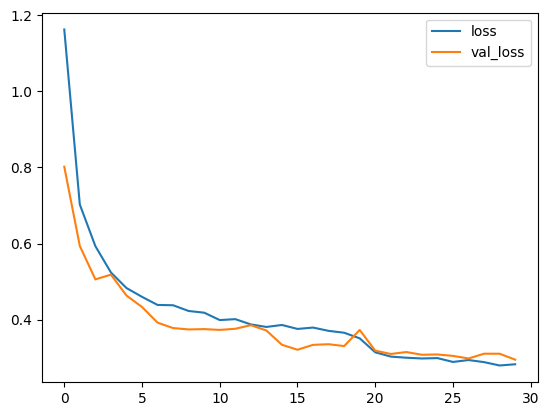

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [ ]:
test_steps = test_gen.samples // BATCH_SIZE

test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print('\naccuracy:', test_acc, 'loss: ',test_loss)

51/51 [==============================] - 12s 234ms/step - loss: 0.3411 - f1_macro: 0.8558

accuracy: 0.8557679653167725 loss:  0.3411320745944977


In [ ]:
predict = model.predict(test_gen, steps=test_steps)
y_hat = np.argmax(predict, axis=1)
y_hat[:20]

51/51 [==============================] - 11s 214ms/step


array([3, 1, 1, 0, 3, 2, 0, 1, 1, 0, 3, 2, 3, 0, 1, 0, 3, 0, 0, 3])

In [ ]:
test_labels_df = pd.DataFrame()
test_labels_df[['class']] = test_data[['class']]

change = {
'0' : 0,
'1' : 1,
'2' : 2,
'3' : 3,
}

test_labels_df['class'] = test_labels_df['class'].map(change)
test_labels_df = test_labels_df[ : test_steps*BATCH_SIZE]


y_test = np.array(test_labels_df['class'])
y_test[:20]

array([3, 1, 1, 0, 3, 1, 0, 1, 2, 0, 3, 2, 3, 0, 1, 0, 3, 0, 0, 3])

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       292
           1       0.80      0.86      0.83       266
           2       0.72      0.59      0.65       145
           3       0.99      0.96      0.97       113

    accuracy                           0.87       816
   macro avg       0.87      0.85      0.86       816
weighted avg       0.87      0.87      0.87       816
 



<Axes: >

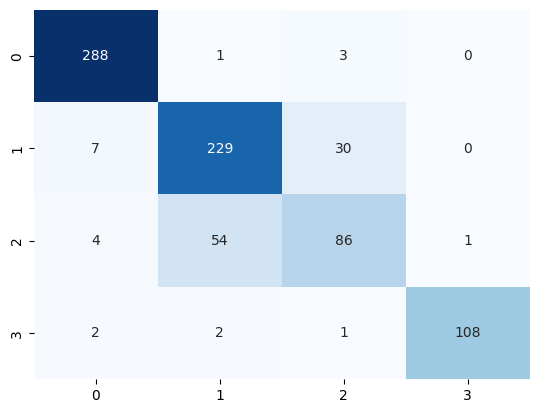

In [ ]:
print(classification_report(y_test, y_hat), '\n')
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/CRUx/Task 2/Models/")

In [ ]:
tf.keras.backend.clear_session() #clear model variables for a new model